<a href="https://colab.research.google.com/github/joelm67/Remote-Sensing-Python/blob/main/Copy_of_change_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change detection with Python

The purpose of this notebook is to introduce change detection concepts using Python.  Remember, digital change detection starts with quantifying the change in reflectance values between two sets of images acquired at different times and *then* relating this change in reflectance to changes in land cover.  The most important question in digital change detection is then to separate observed changes in interest (associated with landscape change) from those changes that are unrelated to land cover.  There are many methods to choose from when performing change detection, here we are going to experiment with a few, namely image differencing, image ratio, and change vector analysis.

Lets get started.  For this example application we will use two images of exact same size, acquired over eastern Washington state forested areas.  Our goal is to detect changes in forested areas between two time periods.  I have prepared two images of the same area, one from summer 2014 and another summer 2019.  They are both Landsat 8 images and each image contains six bands [blue, green, red, NIR, SWIR1, and SWIR2], all of which have been resampled to 30-meter spatial resolution.

In [1]:

!add-apt-repository ppa:ubuntugis/ppa
!apt update
!apt install gdal-bin libgdal-dev
!pip3 install rasterio

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.6/shutil.py", line 486, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/usr/lib/python3.6/shutil.py", line 442, in _rmtree_safe_fd
    os.unlink(name, dir_fd=topfd)
KeyboardInterrupt
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://deve

In [2]:
# grab the 2014 image from a public cloud using wget
!wget https://storage.googleapis.com/alexi_daily/EnvSt956/wa_20140715.tif -O wa_20140715.tif

# grab the 2019 image from a public cloud using wget
!wget https://storage.googleapis.com/alexi_daily/EnvSt956/wa_20190729.tif -O wa_20190729.tif

# list the contents
!ls

# look at one image metadata
!gdalinfo wa_20140715.tif

--2021-01-25 23:19:02--  https://storage.googleapis.com/alexi_daily/EnvSt956/wa_20140715.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11516092 (11M) [image/tiff]
Saving to: ‘wa_20140715.tif’

wa_20140715.tif     100%[===================>]  10.98M  --.-KB/s    in 0.1s    

2021-01-25 23:19:02 (78.0 MB/s) - ‘wa_20140715.tif’ saved [11516092/11516092]

--2021-01-25 23:19:02--  https://storage.googleapis.com/alexi_daily/EnvSt956/wa_20190729.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11369620 (11M) [image/tiff]
Saving to: ‘wa_20190729.tif’

wa

Lets start the process by importing some important libraries

This time we will use another library called `rasterio` to read multiband images.  Note that unlike other image processing libraries, `rasterio` reads multiband images as `<bands> <rows> <cols>`.  There are additional tools that can be used to *reshape* the array so it can be used in an image processing task.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2014 false color composite


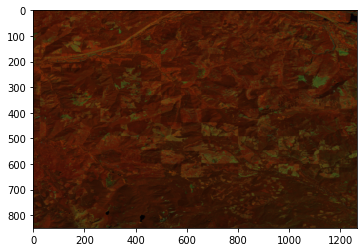

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 850, 1265)
2019 false color composite


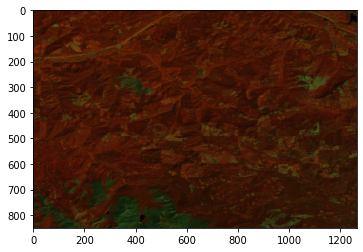

In [3]:
# import these and other libraries
import numpy as np
import random
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt

# read the 2014 dataset
im14 = rasterio.open('wa_20140715.tif').read()
#print(im14.shape)

# visualize false color composite
# images have been scaled by 10000 going from reflectance to scaled reflectance
print('2014 false color composite')
plt.imshow(reshape_as_image(im14[[3,4,2], :]*0.0001))
plt.show()

# read the 2019 dataset
im19 = rasterio.open('wa_20190729.tif').read()
print(im19.shape)

# visualize false color composite
print('2019 false color composite')
plt.imshow(reshape_as_image(im19[[3,4,2], :]*0.0001))
plt.show()

Now that we read our 6 band images, let's start by applying the image differencing technique.   Image differencing is a simple band-by-band arithmetic differencing (e.g. early image[b1] - later image[b1]) operation.  Once the difference image is calculated, then we can use the histogram (or some other method) of the difference image to find **change thresholds** and use these thresholds to identify pixels that have changed between two time periods. Remember the histogram of the change image is almost always normally distributed so this makes it easier to find the threshold.  Let's see an example.

(850, 1265)


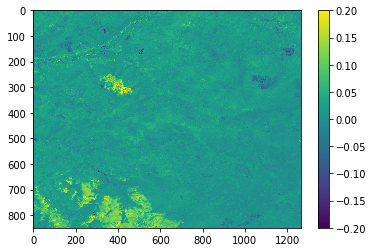

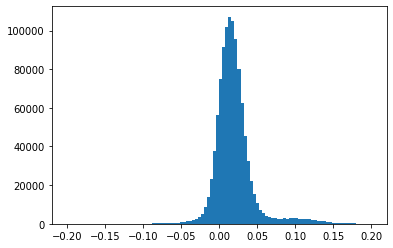

In [4]:
# NIR differencing example
nirdiff = im14[3,:]*0.0001 - im19[3,:]*0.0001
print(nirdiff.shape)
rows = nirdiff.shape[0]
cols = nirdiff.shape[1]

# visualize the difference image
plt.imshow(nirdiff, vmin = -0.2, vmax = 0.2, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

# visualize its histogram
n_bins = 100
N, bins, patches = plt.hist(nirdiff.reshape(rows*cols), bins=n_bins,range=[-0.2, 0.2])

Let's use a threshold on 0.07 (why not!)

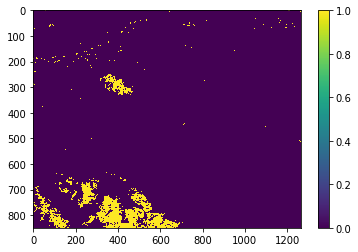

In [ ]:
changeim = nirdiff >= 0.075
#print(changeim)
changeim = changeim.astype(np.uint8)
#print(changeim)

plt.imshow(changeim, vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
file_list = ['wa_20190729.tif', 'nir_change_detection.tif']

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

ValueError: ignored

Write the file to disk as a geotiff image

In [ ]:
im = rasterio.open('wa_20140715.tif')
# start generating variables used for writing the geotiff image
transform = im.transform # transform parameters read from the original image
crs = im.crs # CRS parameters read from the original image

# write the file in one go using all options
def writetiff(file,name): 
  file = file.astype(np.uint8)
  with rasterio.open(
      name,
      'w',
      driver='GTiff',
      height=file.shape[0],
      width=file.shape[1],
      count=1,
      dtype='uint8',
      crs = crs,
      transform=transform,
  ) as dst:
      dst.write(file, 1)

  # check if the file exists
  !gdalinfo nir_change_detection.tif


In [ ]:
writetiff(changendvi, 'changendvi.tif')
from google.colab import files
files.download('changendvi.tif')

Driver: GTiff/GeoTIFF
Files: nir_change_detection.tif
Size is 1265, 850
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-121.539093500933674,47.259648445300733)
Pixel Size = (0.000269494585236,-0.000269494585236)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-121.5390935,  47.2596484) (121d32'20.74"W, 47d15'34.73"N)
Lower Left  (-121.5390935,  47.0305780) (121d32'20.74"W, 47d 1'50.08"N)
Upper Right (-121.1981829,  47.2596484) (121d11'53.46"W, 47d15'34.73"N)
Lower Right (-121.1981829,  47.0305780) (121d11'53.46"W, 47d 1'50.08"N)
Center      (-121.3686382,  47.1451132) (121d22' 7.10"W, 47d 8'42.41"N)
Band 1 Block=1265x6 Type=Byte, ColorInterp=Gray


Now let's try alternative bands (e.g. NDVI)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


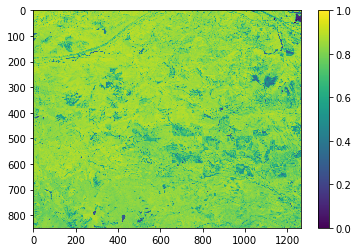

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


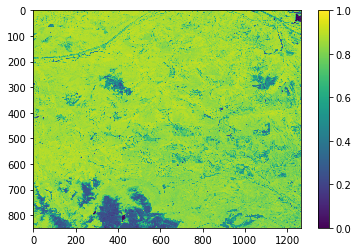

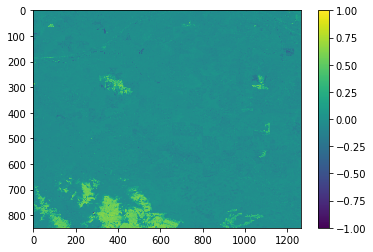

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal


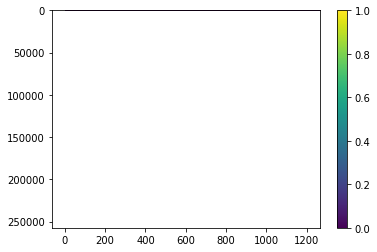

In [ ]:
ndvi14 = (im14[3,:] - im14[2,:]) / (im14[3,:] + im14[2,:])
# visualize the image
plt.imshow(ndvi14, vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

ndvi19 = (im19[3,:] - im19[2,:]) / (im19[3,:] + im19[2,:])
# visualize the image
plt.imshow(ndvi19, vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

ndvidiff = ndvi14 - ndvi19
# visualize the image
plt.imshow(ndvidiff, vmin = -1, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

# visualize its histogram
n_bins = 100
N, bins, patches = plt.hist(ndvidiff.reshape(rows*cols), bins=n_bins,range=[-0.7, 0.7])

changendvi = ndvidiff >= 0.7
#print(changeim)
changendvi = changendvi.astype(np.uint8)
#print(changeim)

plt.imshow(changendvi, vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

How about KT transformation?

In [ ]:
def tasseled_cap_tm(rast, reflectance=True):
    '''
    Applies the Tasseled Cap transformation for TM data. Assumes that the TM
    data are TM reflectance data (i.e., Landsat Surface Reflectance). The
    coefficients for reflectance factor data are taken from Crist (1985) in
    Remote Sensing of Environment 17:302.
    '''
    if reflectance:
        # Reflectance factor coefficients for TM bands 1-5 and 7; they are
        #   entered here in tabular form so they are already transposed with
        #   respect to the form suggested by Kauth and Thomas (1976)
        r = np.array([
            ( 0.2043, 0.4158, 0.5524, 0.5741, 0.3124, 0.2303),
            (-0.1603,-0.2819,-0.4934, 0.7940,-0.0002,-0.1446),
            ( 0.0315, 0.2021, 0.3102, 0.1594,-0.6806,-0.6109),
            (-0.2117,-0.0284, 0.1302,-0.1007, 0.6529,-0.7078),
            (-0.8669,-0.1835, 0.3856, 0.0408,-0.1132, 0.2272),
            ( 0.3677,-0.8200, 0.4354, 0.0518,-0.0066,-0.0104)
        ], dtype=np.float32)

    else:
        raise NotImplemented('Only support for Landsat TM reflectance has been implemented')

    shp = rast.shape

    # Can accept either a gdal.Dataset or numpy.array instance
    if not isinstance(rast, np.ndarray):
        x = rast.ReadAsArray().reshape(shp[0], shp[1]*shp[2])

    else:
        x = rast.reshape(shp[0], shp[1]*shp[2])

    return np.dot(r, x).reshape(shp)


# apply the KT transformation
kt14 = tasseled_cap_tm(im14*0.0001)  
print(kt14.shape)

#print(kt14)

# visualize false color composite
plt.imshow(reshape_as_image(kt14[[0,1,2], :]))
plt.show()

# apply the KT transformation
kt19 = tasseled_cap_tm(im19*0.0001)  
print(kt19.shape)

#print(kt14)

# visualize false color composite
plt.imshow(reshape_as_image(kt19[[0,1,2], :]))
plt.show()

# now compute "wetness" difference image
# wetness is the 3rd KT band
ktdiff = kt14[2,:] - kt19[2,:]

# and same as NDVI differencing, we can choose thresholds and make change 
# images and export them as geotiff images

# display the wetness difference image
#plt.imshow(ktdiff, vmin = -0.3, vmax = 0.3, interpolation='nearest', aspect='auto')
#plt.colorbar()
#plt.show()

Now let's experiment with Change Vector analysis (CVA). CVA uses two dimensions (think of two bands) as points in cartesian coordinates that show differences between two time periods in vector form.  Like all vectors, these "change" vectors have both direction and magnitude, which show the form of change (direction) and intensity of change (magnitude).  Using thresholds, these vectors can then be converted to change images of direction and intensity. For this analysis we are going to use the Red and the NIR bands as the two dimensions.  More specifically, we will use the Red band in the X axis and NIR in the Y axis and produce two scatterplots produced from two dates of images and watch the points (pixels) in the Red-NIR space move to form vectors.

Text(0, 0.5, 'NIR reflectance')

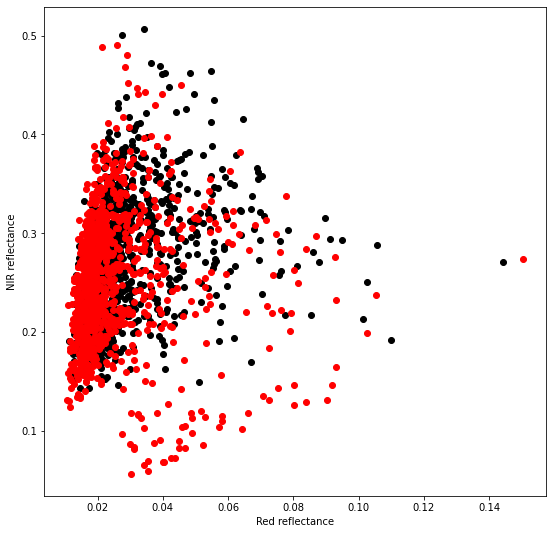

In [ ]:
# lets get our data into a scatterplot

# first select a 1000 sampels at random for a range of data between
# 0 and rows*cols - this is done to simplify the plot
idx=random.sample(range(rows*cols),1000)

# grab 2014 Red and NIR 
im14xy = (im14[[2,3],:]*0.0001).reshape(2,rows*cols)

# grab 2019 Red and NIR 
im19xy = (im19[[2,3],:]*0.0001).reshape(2,rows*cols)

plt.figure(figsize=(9, 9))
plt.plot(im14xy[0,idx], im14xy[1,idx], 'ko', label='2014 data')
plt.plot(im19xy[0,idx], im19xy[1,idx], 'ro', label='2019 data')
plt.xlabel('Red reflectance')
plt.ylabel('NIR reflectance')


To calculate vector length (magnitude) we need to apply vector algebra - we will be using the Eucledian distance for this purpose. See the example:

0.0
0.3956867068780553


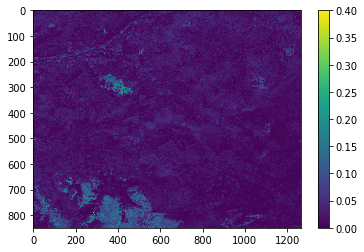

In [ ]:
x1 = im14xy[0,:]
y1 = im14xy[1,:]
x2 = im19xy[0,:]
y2 = im19xy[1,:]

# Euclidean distance calculation 
change_magnitude = np.sqrt((x2-x1)**2 + (y2-y1)**2)

print(change_magnitude.min())
print(change_magnitude.max())

print('change magnitude')
plt.imshow(change_magnitude.reshape(rows,cols), vmin = 0, vmax = 0.4, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

Now the change direction.  note that angles are calculated as **counter clockwise from the horizontal axis** so the vertical axis would be 90 degrees, a vector pointed in Northwest direction would be > 90, vector pointing straight west would be 180 degrees and so on.  To account for different "quadrants" we would need to make adjustments as in:
- x = positive; y = positive = Quadrant I - do nothing
- x = negative; y = positive = Quadrant II - add 180 degrees
- x = negative; y = negative = Quadrant III - add 270
- x = positive; y = negative = Quadrant IV - add 360

                    |
               II   |  I
                    |
            ------------------
                    |
              III   |  IV
                    |


In [ ]:
# generate vector components for convenience
a = x2 - x1
b = y2 - y1

# calculate change direction as degrees.  Note that arctan returns results 
# in radians and np.degrees converts that to degrees
change_direction = np.degrees(np.arctan(b/a))

# correct for quadrants
change_direction[(a < 0) & (b > 0)] = change_direction[(a < 0) & (b > 0)] + 180.0
change_direction[(a > 0) & (b < 0)] = change_direction[(a > 0) & (b < 0)] + 360.0

#print(np.nanmin(change_direction))
#print(np.nanmax(change_direction))

print('change direction')
plt.imshow(change_direction.reshape(rows,cols), vmin = 0, vmax = 360, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

# as you can see most of the change associated with forest removal is assigned
# to change direction od 300+ degrees meaning reduction in NIR and increase in 
# Red reflectance, which is exactly what you would expect when vegetation is
# decreased.

# illustrate the vectors
idx=random.sample(range(rows*cols),10)
plt.quiver(x1[idx], y1[idx], x2[idx], y2[idx], units='xy' ,scale=1)
plt.xlim(0,0.4)
plt.ylim(0,1)
plt.show()


Finally, lets find the change based on direction and magnitude

In [ ]:
cva1 = change_magnitude > 0.10 
cva1 = cva1.astype(np.uint8)
print('change magnitude')
plt.imshow(cva1.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

cva2 = change_direction > 280 
cva2 = cva2.astype(np.uint8)
print('change direction')
plt.imshow(cva2.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()